# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Vegan restaurant** in **Goiânia**, Brazil.

Since there aren't many vegan restaurants in Goiânia we will try to detect **locations that are mostly likely to receive well a new vegan restaurant** looking to places that alreary are this kind of restaurant and detecting similar neighborhoods. We are also particularly interested in **areas close to city center as possible**.

We will use our data science powers to generate a few most promissing neighborhoods based os this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:

* number of existing restaurantes in the neighborhood (any type of restaurant)
* number of Vegan restaurants int he neighborhood, if any
* similarity between neighborhoods
* distance of neighborhood from city center
    
Following data sources will be neede to extract/generate the required information:

* centers of candidate areas will be generated algoritmically using **Geopandas package**
* number of restaurantes and their type and location in every neighborhood will be obtained using Foursquare API
* coordinate of Goiânia center will be obtained using **Geopandas package**

### Neighborhood Candidates

1. Scraping the page [https://nominatim.openstreetmap.org/details.php?osmtype=R&osmid=334547&class=boundary] from Open Street Map to importing Goiânia borough data
2. Pre-processing Borough data
3. Getting Borough data Coordinates
4. Pre-processing Coodinates data


#### 1. Scraping page to import Goiânia borough data

Importing necessary Libraries

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.firefox.options import Options

import pandas as pd
import numpy as np

Scraping and cleaning the pages

In [2]:
   # Set the path to chromedriver
url = r"https://nominatim.openstreetmap.org/details.php?osmtype=R&osmid=334547&class=boundary"
    
driver = webdriver.Chrome(r"C:\Users\ErikaS\Documents\Projetos Érika\Coursera__Capstone/chromedriver")

    # Get the url
driver.get(url)

    # Select the div correct and extrating the table in html format
driver.find_element_by_xpath("/html/body/div[2]/div[3]/div/table").click()
element = driver.find_element_by_xpath("/html/body/div[2]/div[3]/div/table")
html_content = element.get_attribute('outerHTML')

    # Close the browser
driver.quit()
    
    # Tranforming
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find(name = 'table')

    # Using pandas to structure the table in a DataFrame
df_full = pd.read_html(str(table))[0]


Let's take a look  in the data we got it

In [3]:
df_full.head()

,Local name,Type,OSM,Address rank,Admin level,Distance,Unnamed: 6
0,Goiânia,boundary:administrative,relation 334547,16.0,8.0,0,details >
1,Microrregião de Goiânia,boundary:administrative,relation 4857379,14.0,7.0,0.1012,details >
2,Região Geográfica Intermediária de Goiânia,boundary:administrative,relation 4873222,10.0,5.0,0.8761,details >
3,Goiás,boundary:administrative(state),relation 334443,8.0,4.0,0.7385,details >
4,Região Centro-Oeste,boundary:administrative,relation 3359944,6.0,3.0,5.2385,details >


We can see that there are some columns we don't need it, and in column 'Type' we have to filter to get only the boroughs

#### 2. Pre-processing Borough data

- The borough data are those who have 'Address rank' >17
- We don't need columns: Type, OSM, Address rank, Admin level and Unnamed: 6
- We need to convert the column Distance to double type


In [4]:
# Selecting only the borough
borough_gyn = df_full[df_full[ 'Address rank'] > 17.0] .sort_values("Local name")

# Selecting useful columns
borough_gyn = borough_gyn.loc[:, ['Local name', 'Distance']]

# Cleaning column Distance
borough_gyn['Distance'] = borough_gyn['Distance'].str.replace(" km", "").str.replace("~", "").str.replace(" m", "").astype(float)

# Excluding duplicate data 
borough_gyn = borough_gyn.groupby('Local name').max()
borough_gyn.reset_index(level=0, inplace=True)

borough_gyn.head()

,Local name,Distance
0,Aldeia do Vale,8.7
1,Alphaville Flamboyant Residencial Araguaia,3.8
2,Bairro Boa Vista,13.6
3,Bairro Capuava,6.6
4,Bairro Feliz,3.0


The meaning of the Borough data columns are shown bellow:

- **Local name:** The Borough names;
- **Distance:** The distance from city center

In [5]:
print("Goiania has {} boroughs".format( borough_gyn.shape[0]))

(333, 2)

The web scraping session needed to be run only one time. Now we will save the data to be used later.

In [6]:
borough_gyn.to_csv("bairros_gyn.csv", index=False)

#### Importing Borough data

Let's import the Borough data scraped before.

In [3]:
import pandas as pd
import numpy as np

borough_gyn = pd.read_csv("bairros_gyn.csv")

Now that we have all the Goiânia Boroughs, we can select only the boroughs that are in a radio of 10 km from the center city.


In [5]:
borough_candidates = borough_gyn[borough_gyn['Distance'] < 10]
print("The new data has {} boroughs".format( borough_candidates.shape[0]))

Dimensions:  (210, 2)


,Local name,Distance
0,Aldeia do Vale,8.7
1,Alphaville Flamboyant Residencial Araguaia,3.8
3,Bairro Capuava,6.6
4,Bairro Feliz,3.0
6,Bairro Santo Hilário,6.1


#### 2. Data coordinates

Importing libraries to get geocoordinates

In [6]:
#!pip install geopandas 
#!pip install geopy
import geopandas as gpd
import pandas as pd

We will use Nominatim API to get the coordinates from Open Street Map, but first we need the coordinate center of Goiânia.

In [7]:
# Center coordinate
center_goiania = gpd.tools.geocode(" Goiânia, GO", provider = 'nominatim', user_agent="imp geocode")
lat_gyn = center_goiania['geometry'][0].x
long_gyn = center_goiania['geometry'][0].y
gyncoor = [long_gyn, lat_gyn]

print('Coordinate of Goiânia, GO", Brazil: {}'.format(gyncoor))

Coordinate of Goiânia, GO", Brazil: [-16.680882, -49.2532691]


With Geopandas we can get all the borrough coordinates passing the list of addresses to the function gpd.tools.geocode as bellow

In [14]:
# Completing the address
address = pd.DataFrame({"ende": borough_candidates['Local name'] + ", Goiânia, GO "})

# Getting the cordinates and storing in a new column Geom
borough_candidates["Geom"]  = gpd.tools.geocode(address["ende"], provider = 'nominatim', user_agent="imp geocode", country_bias = "Brazil")["geometry"]


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
borough_candidates.head()

,Local name,Distance,Geom
0,Aldeia do Vale,8.7,POINT (-49.19967 -16.60501)
1,Alphaville Flamboyant Residencial Araguaia,3.8,POINT (-49.21316 -16.69865)
3,Bairro Capuava,6.6,POINT (-49.32322 -16.65565)
4,Bairro Feliz,3.0,POINT (-49.22855 -16.66210)
6,Bairro Santo Hilário,6.1,POINT (-49.19548 -16.65080)


#### 4. Pre-prcsessing Coodinates data

In [26]:
borough_candidates["Lat"] = borough_candidates['Geom'].map(lambda p: p.x)
borough_candidates["Long"] = borough_candidates['Geom'].map(lambda p: p.y)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Saving the data to be used later

In [29]:
borough_candidates.to_csv("borough_candidates.csv", index=False)

Importing the coodinate data

In [13]:
import pandas as pd
import numpy as np

borough_candidates = pd.read_csv("https://raw.githubusercontent.com/erikastats/Coursera__Capstone/master/borough_candidates.csv")


In [6]:
borough_candidates.head()

,Local name,Distance,Lat,Long
0,Aldeia do Vale,8.7,-49.199667,-16.605009
1,Alphaville Flamboyant Residencial Araguaia,3.8,-49.213159,-16.698653
2,Bairro Capuava,6.6,-49.323221,-16.655652
3,Bairro Feliz,3.0,-49.228554,-16.662100
4,Bairro Santo Hilário,6.1,-49.195476,-16.650797


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [3]:
#!pip install folium
import folium


In [112]:
map_goiania = folium.Map(location=gyncoor, zoom_start=12)
folium.Marker([lat_gyn, long_gyn], popup='Goiania').add_to(map_goiania)
for lat, lon in zip(borough_candidates["Long"], borough_candidates['Lat']):
    folium.Circle([lat, lon], radius=100, color='blue', fill=False).add_to(map_goiania)

map_goiania

### Foursquare

Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name, and we'll make sure to detect and include all the subcategories of specific 'Vegan restaurant' category, as we need info on Vegan restaurants in the neighborhood.

The credentials and Version are defined in hidden cell bellow


In [29]:
CLIENT_ID = 'Z45OVI4OAJU15SXRE5MNYK2GPR1GEREVCYXFMKM11TKPIZWO' # your Foursquare ID
CLIENT_SECRET = 'YH5KRUOP0L53A2OSYVHXGMF3QAB1YOT5VIXNZYHV1W4FXBDZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [30]:
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans

#### Repeat the same process to all the neighborhoods in Goiânia

Now we will search for **food places** in all neighborhoods, but only with data about . The fuction bellow will be used on the process

In [28]:
# Category IDs corresponding to Vegan restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259'

vegan_category = '4bf58dd8d48988d1d3941735'

LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, category, radius=400):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the function with the food category with ration 700 m

In [19]:
goiania_venues = getNearbyVenues(names= borough_candidates['Local name'],
                                   latitudes= borough_candidates['Long'],
                                   longitudes= borough_candidates['Lat'],
                                category = food_category, radius=700
                                  )


Saving the venue data in a csv format

In [20]:
goiania_venues.to_csv("goiania_venues.csv", index=False)

Importing Venue data

In [1]:
import pandas as pd

goiania_venues = pd.read_csv("https://raw.githubusercontent.com/erikastats/Coursera__Capstone/master/goiania_venues.csv")

In [8]:
goiania_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Megaburger's,-16.694582,-49.213653,Fast Food Restaurant
1,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Panificadora Skina do Pão,-16.692809,-49.212366,Bakery
2,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Pizza 10,-16.693148,-49.212926,Pizza Place
3,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Pit Dog XGordo,-16.696231,-49.213708,Burger Joint
4,Alphaville Flamboyant Residencial Araguaia,-16.698653,-49.213159,Restaurante e Pizzaria Tan Tan,-16.693422,-49.211480,Brazilian Restaurant


Let's check how many food places were returned for each neighborhood

In [15]:
borough_candidates.head()

,Local name,Distance,Lat,Long
0,Aldeia do Vale,8.7,-49.199667,-16.605009
1,Alphaville Flamboyant Residencial Araguaia,3.8,-49.213159,-16.698653
2,Bairro Capuava,6.6,-49.323221,-16.655652
3,Bairro Feliz,3.0,-49.228554,-16.662100
4,Bairro Santo Hilário,6.1,-49.195476,-16.650797


In [16]:
top_10_freq = goiania_venues.groupby('Neighborhood', as_index = False)['Venue'].count().sort_values(by = ['Venue'], ascending = False).head(10)
top_10_freq = pd.merge(top_10_freq, goiania_venues[["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"]].drop_duplicates(),
                       on = "Neighborhood", how = 'left')
top_10_freq


,Neighborhood,Venue,Neighborhood Latitude,Neighborhood Longitude
0,Setor Marista,91,-16.699889,-49.262505
1,Setor Bela Vista,74,-16.712725,-49.261247
2,Setor Nova Suiça,62,-16.714054,-49.273101
3,Serrinha,60,-16.722002,-49.265054
4,Setor Alto da Glória,59,-16.713674,-49.239006
5,Setor Pedro Ludovico,55,-16.713730,-49.252743
6,Setor Oeste,54,-16.681220,-49.272167
7,Vila Redenção,51,-16.719182,-49.242267
8,Setor Campinas,43,-16.669283,-49.290375
9,Loteamento Mansões Goianas,41,-16.628135,-49.283511


In [53]:
map_goiania = folium.Map(location=gyncoor, zoom_start=13)
folium.Marker([lat_gyn, long_gyn], popup='Goiania').add_to(map_goiania)
for lat, lon, sizee, label in zip(top_10_freq['Neighborhood Latitude'], top_10_freq["Neighborhood Longitude"],
                                  top_10_freq["Venue"],  top_10_freq["Neighborhood"]):
    folium.CircleMarker([lat, lon],
                        radius= sizee/5,
                        popup = label + ", " + str(sizee) + " Rest.", 
                        color='blue', fill = True,
                        fill_color= "blue",
                        fill_opacity=0.7).add_to(map_goiania)

map_goiania


We cann notice that the densest borroughs are mostly in the same region

Let's find out how many unique categories can be curated from all the returned venues and how many venues was returned

In [25]:
print('There are {} uniques categories.'.format(len(goiania_venues['Venue Category'].unique())))
print('There are {} venues returned.'.format( goiania_venues.shape[0] ))

There are 66 uniques categories.
There are 2482 venues returned.


Now we can get the data about vegan restaurant 1km from the center borough

In [31]:
goiania_Vegan = getNearbyVenues(names= borough_candidates['Local name'],
                                   latitudes= borough_candidates['Long'],
                                   longitudes= borough_candidates['Lat'],
                                category = vegan_category, radius=1000 )

goiania_Vegan.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bairro Capuava,-16.655652,-49.323221,Mixirica Alimentação Equilibrada,-16.654318,-49.329273,Vegetarian / Vegan Restaurant
1,Bairro Capuava,-16.655652,-49.323221,Restaurante Vegetariano,-16.649013,-49.320843,Vegetarian / Vegan Restaurant
2,Chácaras São Francisco de Assis,-16.691562,-49.215991,Experiências Gastronómicas Vegetarianas,-16.685869,-49.216576,Vegetarian / Vegan Restaurant
3,Conjunto Residencial Campus,-16.594930,-49.260465,Jagannatha,-16.600086,-49.258028,Vegetarian / Vegan Restaurant
4,Conjunto Riviera,-16.690267,-49.210240,Experiências Gastronómicas Vegetarianas,-16.685869,-49.216576,Vegetarian / Vegan Restaurant


Saving vegan venue data

In [32]:
goiania_Vegan.to_csv("goiania_Vegan.csv", index=False)

Importing Vegan Venue Data

In [26]:
goiania_Vegan = pd.read_csv("https://raw.githubusercontent.com/erikastats/Coursera__Capstone/master/goiania_Vegan.csv")

In [33]:
print('There are {} uniques Vegan venues.'.format(len(goiania_Vegan['Venue'].unique())))


There are 25 uniques Vegan venues.


In [115]:
goiania_Vegan.groupby('Neighborhood', as_index = False)['Venue'].count().sort_values(by = ['Venue'], ascending = False).head()

,Neighborhood,Venue
22,Serrinha,4
25,Setor Bela Vista,4
28,Setor Marista,4
29,Setor Nova Suiça,3
31,Setor Oeste,3


Let's now see all the collected restaurants in our area of interest on map, and let's also show Vegan restaurants in different color

In [57]:
goiania_venues_unique = pd.concat([goiania_venues[["Venue","Venue Latitude", "Venue Longitude", "Venue Category"]].drop_duplicates(),
                                 goiania_Vegan[["Venue","Venue Latitude", "Venue Longitude", "Venue Category"]].drop_duplicates()])
goiania_venues_unique['color'] = np.where(goiania_venues_unique['Venue Category']=='Vegetarian / Vegan Restaurant', 'red', 'blue')

In [58]:
goiania_venues_unique.tail()

,Venue,Venue Latitude,Venue Longitude,Venue Category,color
42,Loving Hut,-16.708968,-49.278146,Vegetarian / Vegan Restaurant,red
43,Galeria Via Brava,-16.707190,-49.271540,Vegetarian / Vegan Restaurant,red
45,KASSIS Cakes and Cookies,-16.664008,-49.250747,Vegetarian / Vegan Restaurant,red
46,Slim Gastronomia Saudável,-16.686977,-49.265021,Vegetarian / Vegan Restaurant,red
48,Restaurante Macrobiótico - Artemisia,-16.684136,-49.263321,Vegetarian / Vegan Restaurant,red


In [59]:
from IPython.display import display

map_goiania = folium.Map(location=gyncoor, zoom_start=12)
folium.Marker(gyncoor, popup='Goiania').add_to(map_goiania)

for lat, lon, colors, label in zip(goiania_venues_unique["Venue Latitude"], goiania_venues_unique['Venue Longitude'], 
                           goiania_venues_unique['color'], goiania_venues_unique["Venue"] ):
    folium.Circle([lat, lon], radius=10, color= colors, fill=False).add_to(map_goiania)
    #folium.CircleMarker([lat, lon],
    #                    radius= 5,
    #                    popup = label , 
    #                    color= color, fill = True,
    #                    fill_color= color,
    #                    fill_opacity=0.7).add_to(map_goiania)


display(map_goiania)

So now we have all the restaurants in area within few kilometers from Goiânia center, and we know which ones are Vegan restaurants! We also know which restaurants exactly are in vicinity of every neighborhood candidate center.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Vegan restaurant!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Goiânia that have low restaurant density and have similarity with areas which there are Vegan restaurants. We will limit our analysis to area ~10km around city center.

**First Step:** (this step is done already)
- Collecting the required data: location and category of every restaurant within 10km form Goiânia center
- Identifing Vegan restaurants: according to Foursquare categorization

**Second Step:**
- Clusterization of neighborhoods: using KMeans to cluster it with k = 8
- Identify the cluster that are most Vegan restaurants

**Third Step**
- Calculating the restaurant density in the chossen cluster neighborhoods 
- Identifing the most promising areas with some criteria: 
    - location without Vegan restaurants in radius of 400 meters

## Analysis <a name="analysis"></a>

### Second Step

#### Analyzing each neighborhood

In [60]:
# one hot encoding
goiania_onehot = pd.get_dummies(goiania_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
goiania_onehot['Neighborhood'] = goiania_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [goiania_onehot.columns[-1]] + list(goiania_onehot.columns[:-1])
goiania_onehot = goiania_onehot[fixed_columns]

print("Size Goiania One Hot encoding: ", goiania_onehot.shape)
goiania_onehot.head()

Size Goiania One Hot encoding:  (2482, 67)


,Neighborhood,Acai House,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Baiano Restaurant,Bakery,...,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapiocaria,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alphaville Flamboyant Residencial Araguaia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mena of the frequency of occurrence of each category

In [61]:
goiania_grouped = goiania_onehot.groupby('Neighborhood').mean().reset_index()
print("Size Goiania One Hot encoding: ", goiania_grouped.shape)
goiania_grouped.head()

Size Goiania One Hot encoding:  (196, 67)


,Neighborhood,Acai House,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Baiano Restaurant,Bakery,...,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapiocaria,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,Alphaville Flamboyant Residencial Araguaia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.230769,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Bairro Capuava,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.047619,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0
2,Bairro Feliz,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.181818,...,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bairro Santo Hilário,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Chácara Mansões Rosa de Ouro,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Let's find the top 10 most common venues per beihborhood. First, let's write a function to sort the venues in descending order

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [63]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = goiania_grouped['Neighborhood']

for ind in np.arange(goiania_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(goiania_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alphaville Flamboyant Residencial Araguaia,Bakery,Restaurant,Brazilian Restaurant,Burger Joint,Pizza Place,Fast Food Restaurant,Diner,Comfort Food Restaurant,Creperie,Deli / Bodega
1,Bairro Capuava,Fast Food Restaurant,Pizza Place,Brazilian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Café,Comfort Food Restaurant,Japanese Restaurant,Diner,Bakery
2,Bairro Feliz,Bakery,Pizza Place,Snack Place,Breakfast Spot,Brazilian Restaurant,Diner,Sandwich Place,Churrascaria,BBQ Joint,Donut Shop
3,Bairro Santo Hilário,Snack Place,Goiano Restaurant,Restaurant,Diner,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Deli / Bodega,Wings Joint
4,Chácara Mansões Rosa de Ouro,Food Truck,Central Brazilian Restaurant,Food Stand,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant,Empada House,Dumpling Restaurant,Donut Shop


#### Clustering the neighborhoods

Run k-means to cluster the neighborhood into 6 clusters

In [64]:
# set number of clusters
kclusters = 8

goiania_grouped_clustering = goiania_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(goiania_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 3, 3, 1, 2, 3, 3, 3, 4], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [65]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

goiania_merged = borough_candidates.rename(columns = {"Local name": "Neighborhood"})

# merge goiania_grouped with goiania_grouped to add latitude/longitude for each neighborhood
goiania_merged = goiania_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
goiania_merged.dropna(axis = 0, inplace = True)
goiania_merged['Cluster Labels'] = goiania_merged['Cluster Labels'].astype(int)
goiania_merged.head() # check the last columns!

,Neighborhood,Distance,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alphaville Flamboyant Residencial Araguaia,3.8,-49.213159,-16.698653,4,Bakery,Restaurant,Brazilian Restaurant,Burger Joint,Pizza Place,Fast Food Restaurant,Diner,Comfort Food Restaurant,Creperie,Deli / Bodega
2,Bairro Capuava,6.6,-49.323221,-16.655652,3,Fast Food Restaurant,Pizza Place,Brazilian Restaurant,Burger Joint,Vegetarian / Vegan Restaurant,Café,Comfort Food Restaurant,Japanese Restaurant,Diner,Bakery
3,Bairro Feliz,3.0,-49.228554,-16.662100,3,Bakery,Pizza Place,Snack Place,Breakfast Spot,Brazilian Restaurant,Diner,Sandwich Place,Churrascaria,BBQ Joint,Donut Shop
4,Bairro Santo Hilário,6.1,-49.195476,-16.650797,3,Snack Place,Goiano Restaurant,Restaurant,Diner,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Deli / Bodega,Wings Joint
5,Chácara Mansões Rosa de Ouro,9.5,-49.337225,-16.639185,1,Food Truck,Central Brazilian Restaurant,Food Stand,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant,Empada House,Dumpling Restaurant,Donut Shop


Let's visualize the resulting clusters

In [66]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [67]:
#!pip install folium
import folium
# create map
map_clusters = folium.Map(location=gyncoor, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(goiania_merged['Long'], goiania_merged['Lat'], goiania_merged['Neighborhood'],
                                  goiania_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color= "#222222", #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Some description analysis

In [68]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
cluster_count = goiania_merged.groupby("Cluster Labels", as_index = False)['Neighborhood'].count()
cluster_count



,Cluster Labels,Neighborhood
0,0,6
1,1,9
2,2,14
3,3,115
4,4,46
5,5,2
6,6,2
7,7,2


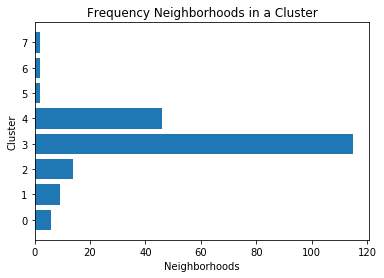

In [70]:
# Create horizontal bars
plt.barh(cluster_count["Cluster Labels"], cluster_count["Neighborhood"])
 
# Create names on the y-axis
#plt.yticks(y_pos, bars)

plt.title("Frequency Neighborhoods in a Cluster")
plt.ylabel("Cluster")
plt.xlabel("Neighborhoods")
# Show graphic
plt.show()

We can see that most neighborhoods fit the group 3

Labeling Vegan data according to Goiania Venue data

In [72]:
# Merging Goiania Venue with Goiania Vegan

vegan_merged = pd.merge(goiania_Vegan, goiania_merged.loc[:, ["Neighborhood", "Distance", "Cluster Labels"]], on = "Neighborhood", how = 'left' )
vegan_merged.head(2)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Cluster Labels
0,Bairro Capuava,-16.655652,-49.323221,Mixirica Alimentação Equilibrada,-16.654318,-49.329273,Vegetarian / Vegan Restaurant,6.6,3
1,Bairro Capuava,-16.655652,-49.323221,Restaurante Vegetariano,-16.649013,-49.320843,Vegetarian / Vegan Restaurant,6.6,3


Let's take a  look the clusters in a map

In [73]:
# create map
map_clusters = folium.Map(location=gyncoor, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vegan_merged['Neighborhood Latitude'], vegan_merged['Neighborhood Longitude'], vegan_merged['Neighborhood'],
                                  vegan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color= "#222222", #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

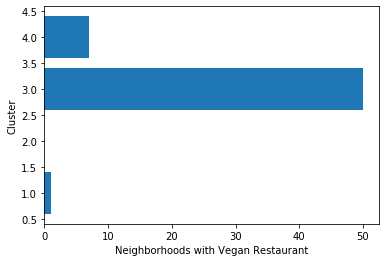

In [74]:
cluster_vegan = vegan_merged.groupby("Cluster Labels", as_index = False)['Neighborhood'].count()
# Create horizontal bars
plt.barh(cluster_vegan["Cluster Labels"], cluster_vegan["Neighborhood"])
 
# Create names on the y-axis
#plt.yticks(y_pos, bars)

#plt.title("Frequency Neighborhoods in a Cluster")
plt.ylabel("Cluster")
plt.xlabel("Neighborhoods with Vegan Restaurant")
# Show graphic
plt.show()

As expected, there are more Vegan Restaurants in cluster 3. That way, we will choose the Neighborhoods in cluster 3 to continue our discussion, because we can conclude that the neighborhoods in that are more likely to accept a new Vegan restaurant due to the similarity with the neighborhoods that there already are this kind of establishment.

Now we will reduce our data to only neighborhoods in cluster 3 and calculate the restaurants density a distance to city center.

In [116]:
# Merging cluster with goiania venues
venue_merged = pd.merge(goiania_venues,goiania_merged.loc[:, ["Neighborhood", "Distance", "Cluster Labels"]], on = "Neighborhood", how = 'left' )

# Filtering cluster 1
goiania_k1 = venue_merged[venue_merged['Cluster Labels'] == 3]

print("THe new data has {} boroughs".format(goiania_k1.shape[0]))
goiania_k1.dropna(axis = 0, inplace = True)
goiania_k1["Neighborhood"].value_counts().head(10)


THe new data has 2050 boroughs


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Setor Marista                 91
Setor Bela Vista              74
Setor Nova Suiça              62
Serrinha                      60
Setor Alto da Glória          59
Setor Pedro Ludovico          55
Setor Oeste                   54
Vila Redenção                 51
Setor Campinas                43
Loteamento Mansões Goianas    41
Name: Neighborhood, dtype: int64

#### Calculating distance between the Neighborhood to the venue

In [81]:
#!pip install mpu
import mpu

# Converting LAt, Long in a column
goiania_k1['lat_long_Neigh'] = goiania_k1[['Neighborhood Latitude', 'Neighborhood Longitude']].apply(tuple, axis=1)
goiania_k1['lat_long_Venue'] = goiania_k1[['Venue Latitude', 'Venue Longitude']].apply(tuple, axis=1)
goiania_k1.dropna(axis = 0, inplace = True)

# Creating the Coluns Distance between the Neighborhood and the Venue
goiania_k1['Dist_neigh_venue'] = 0

# Calculating the distance  between the Neighborhood and the Venue
for i in range(0, goiania_k1.shape[0]):
    coords_1 = tuple(goiania_k1['lat_long_Neigh'])[i]
    coords_2 = tuple(goiania_k1['lat_long_Venue'])[i]
    goiania_k1.loc[i,['Dist_neigh_venue']] = round(mpu.haversine_distance(coords_1, coords_2) , 3)



Calculating the density of restaurants in a radio of 600 meters

In [85]:
# Filtering the distances < 0.6km
goiania_600 = goiania_k1[ goiania_k1.Dist_neigh_venue < 0.6 ]

# Counting the restaurants per neighborhood
freq = goiania_600.groupby('Neighborhood', as_index = False)['Venue'].count().sort_values(by = ['Venue'], ascending = False)

print("Filtred Neighborhood", freq.shape)
freq.head()
#print(goiania_600.shape)
#goiania_600.head()

Filtred Neighborhood (113, 2)


,Neighborhood,Venue
72,Setor Bela Vista,64
79,Setor Marista,61
106,Vila Redenção,51
69,Serrinha,49
88,Setor Oeste,48


In [83]:
freq.Venue.mean()

14.274336283185841

There are, aproximaly, 14 restaurants at 600 m to the center of each neighborhood

#### Calculating distance between each the Neighborhood to the Vegan resturant

In [78]:
vegan_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance,Cluster Labels
0,Bairro Capuava,-16.655652,-49.323221,Mixirica Alimentação Equilibrada,-16.654318,-49.329273,Vegetarian / Vegan Restaurant,6.6,1
1,Chácaras São Francisco de Assis,-16.691562,-49.215991,Experiências Gastronómicas Vegetarianas,-16.685869,-49.216576,Vegetarian / Vegan Restaurant,4.0,1
2,Conjunto Residencial Campus,-16.594930,-49.260465,Jagannatha,-16.600086,-49.258028,Vegetarian / Vegan Restaurant,9.3,1
3,Jardim Goiás,-16.702417,-49.238597,Espaço Vida Saudável Herbalife,-16.706307,-49.240382,Vegetarian / Vegan Restaurant,1.0,1
4,Jardim Nova Esperança,-16.644774,-49.324152,Restaurante Vegetariano,-16.649013,-49.320843,Vegetarian / Vegan Restaurant,7.5,1


In [93]:
# Getting only the Vegan restaurant and it coordinates
vegan_rest = vegan_merged[["Venue", "Venue Latitude", "Venue Longitude"]]
vegan_rest['lat_long_Venue'] = vegan_rest[["Venue Latitude", "Venue Longitude"]].apply(tuple, axis=1)
vegan_rest.dropna(axis = 0, inplace = True)


# Getting only the restaurants and their coordinates
goiania_bair = goiania_k1[["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude"]].drop_duplicates()
goiania_bair['lat_long_Neigh'] = goiania_bair[["Neighborhood Latitude", "Neighborhood Longitude"]].apply(tuple, axis=1)
goiania_bair.dropna(axis = 0, inplace = True)

Vegan_Dist = pd.DataFrame({"Neighborhood" : [], "Neighborhood Latitude": [], "Neighborhood Longitude": [],"lat_long_Neigh": [],
                           "Venue": [], "Venue Latitude": [], "Venue Longitude": [], "lat_long_Venue": [],
                           "Distan_Vegan": [] })

# Calculating the distance between vegan restaurants and the neighborhood
for i in range(0, goiania_bair.shape[0]):
    coords_1 = tuple(goiania_bair['lat_long_Neigh'])[i]
    for j in range(0, vegan_rest.shape[0]):
        coords_2 = tuple(vegan_rest['lat_long_Venue'])[j]
        dist = round(mpu.haversine_distance(coords_1, coords_2) , 3)
        df = pd.DataFrame({"Neighborhood" : [goiania_bair.iat[i,0]], "Neighborhood Latitude": [goiania_bair.iat[i,1]],
                           "Neighborhood Longitude": [goiania_bair.iat[i,2]],"lat_long_Neigh": [goiania_bair.iat[i,3]],
                           "Venue": [vegan_rest.iat[j,0]], "Venue Latitude": [vegan_rest.iat[j,1]],
                           "Venue Longitude": [vegan_rest.iat[j,2]], "lat_long_Venue": [vegan_rest.iat[j,3]],
                           "Distan_Vegan": [dist] })

        Vegan_Dist = pd.concat([Vegan_Dist, df], ignore_index=True)


Vegan_Dist.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,lat_long_Neigh,Venue,Venue Latitude,Venue Longitude,lat_long_Venue,Distan_Vegan
0,Bairro Capuava,-16.655652,-49.323221,"(-16.6556515, -49.3232214)",Mixirica Alimentação Equilibrada,-16.654318,-49.329273,"(-16.654318, -49.329273)",0.662
1,Bairro Capuava,-16.655652,-49.323221,"(-16.6556515, -49.3232214)",Restaurante Vegetariano,-16.649013,-49.320843,"(-16.64901346537927, -49.320843023373)",0.780
2,Bairro Capuava,-16.655652,-49.323221,"(-16.6556515, -49.3232214)",Experiências Gastronómicas Vegetarianas,-16.685869,-49.216576,"(-16.68586899465252, -49.21657611679148)",11.846
3,Bairro Capuava,-16.655652,-49.323221,"(-16.6556515, -49.3232214)",Jagannatha,-16.600086,-49.258028,"(-16.60008600832091, -49.25802826881409)",9.296
4,Bairro Capuava,-16.655652,-49.323221,"(-16.6556515, -49.3232214)",Experiências Gastronómicas Vegetarianas,-16.685869,-49.216576,"(-16.68586899465252, -49.21657611679148)",11.846


Calculating the density of vegan restaurants in a radio of 1 km in each neighborhood

In [94]:
# Filtering the distances < 1km
vegan_600 = Vegan_Dist[ Vegan_Dist.Distan_Vegan <=  1 ]

# Counting the restaurants per neighborhood
freqV = vegan_600.groupby('Neighborhood', as_index = False)['Venue'].count().sort_values(by = ['Venue'], ascending = False)

print("Filtred Neighborhood", freqV.shape)
freqV.head()
#print(goiania_600.shape)
#goiania_600.head()

Filtred Neighborhood (32, 2)


,Neighborhood,Venue
0,Bairro Capuava,9
25,Setor Nova Suiça,9
23,Setor Cândida de Morais,9
18,Serrinha,9
13,Residencial Morada do Bosque,8


#### Neighborhood selection criteria

- Restaurants frequency between 1º quantile and 2º quantile
- Vegan restaurants frequency < 3 Vega restaurant in 1km meters near the neighborhood
- Distance < 6km  to center city

In [95]:
#Renaming the frequencies with the respective columns to be clearer
freqV.rename(columns = {"Venue" : "Freq_Vegan_600"}, inplace = True)
freq.rename(columns = {"Venue" : "Freq_Rest_600"}, inplace = True)

# Getting the unique values from goiania_k1
gyn = goiania_k1[["Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude", "Distance"]].drop_duplicates()

# Merging the restaurants frequencies with the coordinates and distance from center city
gyn = pd.merge(gyn, freq, on = "Neighborhood", how = 'left')
gyn = pd.merge(gyn, freqV, on = "Neighborhood", how = 'left')
gyn.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance,Freq_Rest_600,Freq_Vegan_600
0,Bairro Capuava,-16.655652,-49.323221,6.6,13.0,9.0
1,Bairro Feliz,-16.662100,-49.228554,3.0,9.0,NaN
2,Bairro Santo Hilário,-16.650797,-49.195476,6.1,2.0,NaN
3,Chácara Rio Branco,-16.625123,-49.286916,7.0,9.0,NaN
4,Chácara do Governador,-16.728732,-49.220552,6.3,6.0,NaN


Cleaning the data

In [96]:
# excluding rows NaN
id_na = pd.isnull(gyn["Distance"])
gyn = gyn[~id_na]

# Replace NaN with 0
gyn.fillna(0, inplace = True)
gyn.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance,Freq_Rest_600,Freq_Vegan_600
0,Bairro Capuava,-16.655652,-49.323221,6.6,13.0,9.0
1,Bairro Feliz,-16.662100,-49.228554,3.0,9.0,0.0
2,Bairro Santo Hilário,-16.650797,-49.195476,6.1,2.0,0.0
3,Chácara Rio Branco,-16.625123,-49.286916,7.0,9.0,0.0
4,Chácara do Governador,-16.728732,-49.220552,6.3,6.0,0.0


Filtering according to criteria

In [117]:
# Restaurants frequency between 1ª quantile and 2ª quantile
#aveg_Rest = gyn["Freq_Rest_600"].mean()
median_Rest = gyn["Freq_Rest_600"].median()
first_Rest = gyn["Freq_Rest_600"].quantile(q=0.25)
gyn_filtered = gyn[(gyn["Freq_Rest_600"] >= first_Rest) & (gyn["Freq_Rest_600"] <= median_Rest) ]

# Vegan restaurants frequency < 2 Vega restaurant in 600 meters near the neighborhood
gyn_filtered = gyn_filtered[gyn_filtered["Freq_Vegan_600"] < 3]


# 6 km to the center city
gyn_filtered = gyn_filtered[gyn_filtered["Distance"] <=6 ]

print("Quantite of promising area: ", gyn_filtered.shape[0])
# Proximity to center city
gyn_filtered.sort_values(by = ['Distance'])
#gyn_filtered.sort_values(by = ['Freq_Rest_600'])


Quantite of promising area:  13


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Distance,Freq_Rest_600,Freq_Vegan_600
110,Vila Romana,-16.675960,-49.228403,2.4,5.0,0.0
97,Vila Bandeirantes,-16.671603,-49.226665,2.6,8.0,0.0
44,Osvaldo Rosa,-16.665742,-49.231202,2.9,9.0,0.0
1,Bairro Feliz,-16.662100,-49.228554,3.0,9.0,0.0
106,Vila Morais,-16.664340,-49.221408,3.1,7.0,0.0
39,Jardim das Esmeraldas,-16.652849,-49.277073,4.0,5.0,0.0
61,Residencial Morumbi,-16.647055,-49.278821,4.1,6.0,0.0
20,Jardim Califórnia,-16.682808,-49.206815,4.3,8.0,0.0
19,Jardim Brasil,-16.695077,-49.210455,4.4,10.0,0.0
111,Vila Roriz,-16.639066,-49.265592,4.5,5.0,0.0


Let's take a look on the remained neighborhoods

In [110]:
# create map
map_gyn_filtered = folium.Map(location=gyncoor, zoom_start=13)

# add markers to the map
markers_colors = []
for lat, lon, poi, rest in zip(gyn_filtered['Neighborhood Latitude'], gyn_filtered['Neighborhood Longitude'], gyn_filtered['Neighborhood'],
                                  gyn_filtered['Freq_Rest_600']):
    label = folium.Popup(str(poi) + ' Freq ' + str(rest), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=rest,
        popup=label,
        color="blue",
        fill=True,
        fill_color= "#222222", #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_gyn_filtered)
       
map_gyn_filtered

This concludes our analysis. We have 13 addresses representing center of zones containing locations with low number of restaurants and with no Vegan restaurants nearby, all zones being fairly close to city center (all less than 6 km). Most of them are located in peripheral neighborhoods.

## Results and Discussion <a name="results"></a>

Our analysis shows that there is a great number of restaurants in Goiânia (~2400 in our initial area of interest which was 10x10km around center city).Highest concentration of restaurants was detected South Zone that we can consider as Goiânia's gastronomic pole.

After identify the amount of restaurants in whole city, we decided devised the borough in clusters (k = 8) to identify the similarity between the neighborhoods. With the data clustered it was possible to recognize which cluster had more vegan restaurants. It was cluster 3, than the neighborhoods in there were classified as that ones with a high similarity in terms of restaurants. In this way, we see that the new restaurant will be more successful in one of these boroughs. In this cluster there are 2050 boroughs.

After directing our attention to this group, we first created a dense grid of restaurants per borough (amount of restaurants in a radius of 600 m from the borough center) and also a dense grid of vegan restaurants per borough (amount of vegan restaurants in a radius of 1 km from the borough center). With these informations, we used 3 criteria to filter the data:

- Restaurants frequency between 1º quantile and 2º quantile: We believe that those locations that have few or no one restaurant are to risky to begin this kind of restaurant because it has a very specific public. On the other hand, The localities that there are a large amount of restaurants (we consider large amount more than the median) is risky because the competitiveness is high and it may compromise the new establishment.
- Vegan restaurants frequency has to be less than  3 Vegan restaurant in 1km meters near the neighborhood.
- Distance to the center city has to be less than 6km.

Those criteria resulted of 13 zones with the largest potential to allocate the new restaurant. But it's important to examine deeper these resulted positions. It's essential research about security, if there are social places nearby and others economic indicators. We also have 2 recommendations for the start, each one based on their owns characteristics:

- **Jardim Brasil**: It's near to government agencies, leisure places (Flamboyant park, Oscar Niemeyer, Flamboyant Shopping Mall, Serra Dourada Stadium, Goiânia Arena), and it is near to luxury condominiums.
- **Parque Amazonia**: It's in the same area as the gastronomic hub (South zone), but has the advantage of not having so many restaurants in the region.

## Conclusion  <a name="conclusion"></a>

Purpose of this project was to identify Goiânia areas close to center with low number of restaurants (particularly Vegan restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Vegan restaurant.

We recommend 13 locations, in specialty 2, but the final decision will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone  taking into consideration additional factors like security, attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.